In [52]:
import torch

In [53]:
import sys
sys.path.append('..')

In [54]:
from models.faster_rcnn import FasterRCNN

In [55]:
# path = '/home/gregschuit/projects/Hammer/repo/work_dirs/faster_rcnn_imagenome_locations/checkpoints/checkpoint-010000.pth'
# path = '/home/gregschuit/projects/Hammer/repo/work_dirs/faster_rcnn_imagenome_locations_w_loss_metrics_lr5e-4/checkpoints/checkpoint-010000.pth'
# path = '/home/gregschuit/projects/Hammer/repo/work_dirs/faster_rcnn_imagenome_locations_w_loss_metrics_lr5e-4_lr5e-5/checkpoints/checkpoint-047000.pth'
# path = '/home/gregschuit/projects/Hammer/repo/work_dirs/faster_rcnn_imagenome_locations_w_loss_metrics_lr5e-4_lr5e-5_lr5e-6/checkpoints/checkpoint-015500.pth'
# path = '/home/gregschuit/projects/Hammer/repo/work_dirs/faster_rcnn_imagenome_locations_lr5e-5/checkpoints/checkpoint-030000.pth'
path = '/home/gregschuit/projects/Hammer/repo/work_dirs/faster_rcnn_imagenome_locations_lr5e-5_lr5e-6/checkpoints/checkpoint-006000.pth'
checkpoint = torch.load(path, map_location='cpu')

In [56]:
model = FasterRCNN(
    pretrained=False,
    progress=True,
    num_classes=37,
    pretrained_backbone=False,
    trainable_backbone_layers=None,
)

model.load_state_dict(checkpoint['models']['frcnn'])

/home/gregschuit/projects/Hammer/venv/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/gregschuit/projects/Hammer/venv/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/gregschuit/projects/Hammer/venv/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/gregschuit/projects/Hammer/v

<All keys matched successfully>

In [57]:
from datasets.object_detection_dataset import ObjectDetectionDataset


ANNOTATIONS_LOCATIONS_PATH_TRAIN="/home/gregschuit/projects/med-region-based-cf/data/annotations/locations_train.json"
ANNOTATIONS_LOCATIONS_PATH_VAL="/home/gregschuit/projects/med-region-based-cf/data/annotations/locations_val.json"
MIMIC_CXR_JPG_DIR_TRAIN="/mnt/workspace/mimic-cxr-jpg/images-256-imagenome-splits/train"
MIMIC_CXR_JPG_DIR_VAL="/mnt/workspace/mimic-cxr-jpg/images-256-imagenome-splits/valid"

In [58]:
train_ds = ObjectDetectionDataset(
    root_dir=MIMIC_CXR_JPG_DIR_TRAIN,
    file_format='png_dir',
    annotation_path=ANNOTATIONS_LOCATIONS_PATH_TRAIN,
    annotation_meta=None,
    annotation_format='json',
    max_samples=-1,
    transform_kwargs=dict(
        image_size=256,
    ),
    num_classes=36,
    mirror=False,
)

val_ds = ObjectDetectionDataset(
    root_dir=MIMIC_CXR_JPG_DIR_VAL,
    file_format='png_dir',
    annotation_path=ANNOTATIONS_LOCATIONS_PATH_VAL,
    annotation_meta=None,
    annotation_format='json',
    max_samples=-1,
    transform_kwargs=dict(
        image_size=256,
    ),
    num_classes=37,
    mirror=False,
)

In [59]:
len(train_ds), len(val_ds)

(166505, 23951)

In [60]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    collated_batch = tuple(zip(*batch))
    return dict(zip(['image', 'targets'], collated_batch))

val_dl = DataLoader(val_ds, batch_size=4, collate_fn=collate_fn)

In [61]:
next(iter(val_dl))

{'image': (tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]]),
  tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]]),
  tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]]),
  tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
   

In [97]:
model = model.eval()

In [98]:
from PIL import Image, ImageDraw
import torchvision.transforms as T
import numpy as np

In [99]:
to_pil_image = T.ToPILImage()

In [100]:
def draw_bbox(img, x1, x2, y1, y2):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle((x1, y1, x2, y2))
    return img

def draw_bboxes(img, boxes):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    for x1, y1, x2, y2 in boxes:
        draw.rectangle((x1, y1, x2, y2))
    return img

In [101]:
LOCATIONS_ORDER = [
    'abdomen',
    'aortic arch',
    'cardiac silhouette',
    'carina',
    'cavoatrial junction',
    'descending aorta',
    'left apical zone',
    'left cardiac silhouette',
    'left cardiophrenic angle',
    'left clavicle',
    'left costophrenic angle',
    'left hemidiaphragm',
    'left hilar structures',
    'left lower lung zone',
    'left lung',
    'left mid lung zone',
    'left upper abdomen',
    'left upper lung zone',
    'mediastinum',
    'right apical zone',
    'right atrium',
    'right cardiac silhouette',
    'right cardiophrenic angle',
    'right clavicle',
    'right costophrenic angle',
    'right hemidiaphragm',
    'right hilar structures',
    'right lower lung zone',
    'right lung',
    'right mid lung zone',
    'right upper abdomen',
    'right upper lung zone',
    'spine',
    'svc',
    'trachea',
    'upper mediastinum',
]

gold_ds_eval_locations = [
    'aortic arch', 'svc', 'trachea', 'carina', 'upper mediastinum'
    , 'cavoatrial junction', 'right atrium', 'cardiac silhouette'
#, 'mediastinum' # mediastinum was re-derived from annotations from cardiac silhouette and upper mediastinum
, 'left apical zone', 'left upper lung zone', 'left mid lung zone', 'left lower lung zone', 'left lung'
, 'right apical zone' , 'right upper lung zone', 'right mid lung zone', 'right lower lung zone', 'right lung'
, 'left clavicle', 'right clavicle'
, 'left hilar structures', 'right hilar structures'
, 'left costophrenic angle', 'right costophrenic angle'
, 'left hemidiaphragm', 'right hemidiaphragm'
#, 'left upper abdomen', 'right upper abdomen' # not in NLP evaluation
#,'abdomen' # not directly annotated but can be derived from the hemidiaphragms to lower border of CXR images
]

In [102]:
def draw_location_by_name(img, name, labels, boxes):
    loc_id = LOCATIONS_ORDER.index(name) + 1
    idx = labels.index(loc_id)
    box = boxes[idx]
    img = img.copy()
    draw = ImageDraw.Draw(img)
    factor = 256 / 224
    box = [value * factor for value in box]
    draw.rectangle(box)

    return img

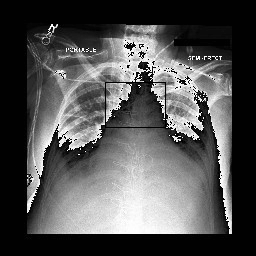

In [103]:
img, targets = val_ds[1]
out = model([img], None)[0]
labels = out['labels'].tolist()
boxes = [box.tolist() for box in out['boxes']]


draw_location_by_name(
    to_pil_image(img),
    'trachea',
    labels,
    boxes,
)

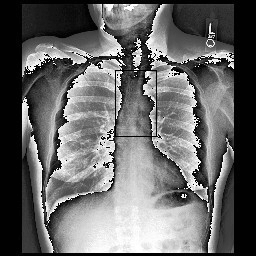

In [104]:
img, targets = train_ds[0]
labels = targets['labels'].tolist()
boxes = [box.tolist() for box in targets['boxes']]

draw_location_by_name(
    to_pil_image(img),
    'trachea',
    labels,
    boxes,
)

In [105]:
from torchvision.ops import box_iou

In [106]:
model.frcnn.rpn.nms_thresh = 0.7

In [107]:
img, targets = val_ds[-1]

real_labels = targets['labels']
real_boxes = targets['boxes']

out = model([img], None)[0]
pred_labels = out['labels'].tolist()
pred_boxes = [box.tolist() for box in out['boxes']]


In [108]:
out

{'boxes': tensor([[ 30.0261,  35.0970, 109.6246, 184.7808],
         [ 18.5695,  40.7522, 106.2940,  67.2229],
         [123.0849,  34.5638, 198.5250, 180.8177],
         [ 46.7894,  39.6935, 109.1472,  91.9541],
         [ 53.0376,  34.6031, 110.3819,  65.6727],
         [125.5045,  39.1119, 186.1829,  91.3364],
         [100.1877,   0.0000, 133.0204, 222.4958],
         [120.9855,  69.6169, 141.9998,  91.6236],
         [122.3233, 165.3203, 198.9997, 223.0266],
         [ 30.2079, 153.6384, 120.1328, 184.4973],
         [ 73.7949,  84.1111, 108.5028, 131.8596],
         [130.8827,  30.0544, 213.0964,  61.8876],
         [102.3106,  52.5141, 145.5652, 114.7869],
         [ 30.8288, 126.3443, 105.2440, 183.6960],
         [ 29.8189, 158.4802, 122.1481, 223.5828],
         [116.8002, 112.4543, 179.1011, 176.1856],
         [101.7413,  69.7297, 120.5962, 116.3139],
         [ 99.0327,  53.1228, 178.6019, 176.6653],
         [125.2276,  33.2572, 180.9206,  67.0277],
         [ 98.8092,  2

In [109]:
np.array(pred_labels)[np.argsort(pred_labels)]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [110]:
np.array(real_labels)[np.argsort(real_labels)]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

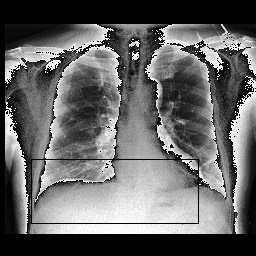

In [76]:
draw_bboxes(to_pil_image(img), np.array(real_boxes)[np.array(real_labels) == 0])

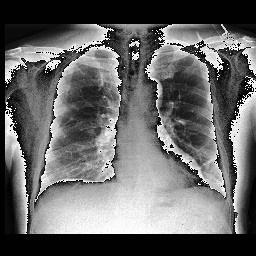

In [77]:
draw_bboxes(to_pil_image(img), np.array(pred_boxes)[np.array(pred_labels) == 0])

In [78]:
pred_scores = out['scores']

In [79]:
pred_scores

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9996, 0.9994, 0.9994, 0.9994,
        0.9993, 0.9990, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987, 0.9984,
        0.9983, 0.9981, 0.9974, 0.9970, 0.9963, 0.9961, 0.9961, 0.9957, 0.9942,
        0.9941, 0.9894, 0.9842, 0.9722, 0.9702, 0.9031, 0.9013, 0.8908, 0.1407],
       grad_fn=<IndexBackward0>)

In [80]:
pred_labels = np.array(pred_labels)
pred_labels

array([28, 23, 14, 31, 19, 17, 32,  1, 16, 25, 26,  9, 35, 27, 30,  7, 33,
       18,  6, 34, 29,  5, 15, 12, 13, 11, 10, 24,  2,  8, 21, 20,  3, 22,
        4, 22])

In [81]:
import pandas as pd

In [82]:
pred_df = pd.DataFrame(
    data={
        'label': pred_labels,
        'box': pred_boxes,
        'score': pred_scores.tolist(),
    }
)

real_df = pd.DataFrame(
    data={
        'label': real_labels,
        'box': [box.tolist() for box in real_boxes],
    }
)

In [83]:
def keep_min_score_for_each_label(df):
    return df.sort_values('score', ascending=False).drop_duplicates(subset='label')

In [84]:
pred_df = keep_min_score_for_each_label(pred_df)


In [85]:
merged = real_df.merge(pred_df, how='left', on='label')
merged

,label,box_x,box_y,score
0,28,"[31, 36, 111, 183]","[30.026081085205078, 35.09701919555664, 109.62...",0.999922
1,31,"[47, 40, 111, 91]","[46.78938293457031, 39.6934928894043, 109.1472...",0.999829
2,29,"[42, 91, 107, 124]","[41.492431640625, 93.10565948486328, 107.44107...",0.997372
3,27,"[31, 124, 105, 183]","[30.828819274902344, 126.34425354003906, 105.2...",0.998836
4,26,"[74, 84, 109, 130]","[73.79485321044922, 84.11112976074219, 108.502...",0.999004
5,19,"[53, 36, 111, 66]","[53.03764343261719, 34.603065490722656, 110.38...",0.999814
6,24,"[21, 168, 41, 188]","[20.194873809814453, 169.28204345703125, 40.40...",0.994148
7,22,"[94, 149, 103, 170]","[95.4483642578125, 149.61004638671875, 103.334...",0.901311
8,25,"[31, 154, 121, 183]","[30.20789909362793, 153.638427734375, 120.1327...",0.999270
9,14,"[124, 33, 198, 179]","[123.0848617553711, 34.56380844116211, 198.524...",0.999859


In [118]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    if float(boxAArea + boxBArea - interArea) != 0:
        iou = interArea / float(boxAArea + boxBArea - interArea)
    else:
        iou = 0
    # return the intersection over union value
    return iou

In [123]:
merged['iou'] = [
    bb_intersection_over_union(A, B)
    if type(B) == list
    else 0
    for A, B in zip(merged['box_x'].values, merged['box_y'].values)
]

In [124]:
merged['iou'].mean()

0.7869001370008126

In [89]:
# With the new dataset, this should be (1, 36, 1, 36) and not (1, 35, 0, 35)
(
    pred_df.label.min(),
    pred_df.label.max(),
    real_df.label.min(),
    real_df.label.max(),
)

(1, 35, 0, 35)

In [125]:
from tqdm import tqdm


model.eval()

ious = []

for img, targets in tqdm(val_ds):
    real_labels = targets['labels']
    real_boxes = [box.tolist() for box in targets['boxes']]

    out = model([img], None)[0]
    pred_labels = out['labels'].tolist()
    pred_boxes = [box.tolist() for box in out['boxes']]
    pred_scores = out['scores'].tolist()

    pred_df = pd.DataFrame(
        data={
            'label': pred_labels,
            'box': pred_boxes,
            'score': pred_scores,
        }
    )
    pred_df = keep_min_score_for_each_label(pred_df)

    real_df = pd.DataFrame(
        data={
            'label': real_labels,
            'box': real_boxes,
        }
    )

    merged = real_df.merge(pred_df, how='left', on='label')
    merged['iou'] = [
        bb_intersection_over_union(A, B)
        if type(B) == list
        else 0
        for A, B in zip(merged['box_x'].values, merged['box_y'].values)
    ]

    ious.append(merged)

  0%|          | 102/23951 [01:36<6:14:48,  1.06it/s]


KeyboardInterrupt: 

In [126]:
ious_df = pd.concat(ious, axis=0)
ious_df

,label,box_x,box_y,score,iou
0,28,"[29, 34, 102, 160]","[29.914981842041016, 32.86978530883789, 101.81...",0.999931,0.956098
1,31,"[40, 39, 102, 85]","[38.40547561645508, 38.46806716918945, 100.949...",0.999743,0.901289
2,29,"[35, 85, 100, 112]","[34.28034210205078, 88.28059387207031, 100.413...",0.997678,0.850515
3,27,"[29, 112, 99, 160]","[29.53941535949707, 112.66720581054688, 100.24...",0.994399,0.966260
4,26,"[67, 79, 101, 117]","[67.50764465332031, 81.58177947998047, 101.025...",0.997548,0.948718
...,...,...,...,...,...
31,3,"[98, 89, 104, 95]","[95.09498596191406, 89.56969451904297, 102.425...",0.352010,0.448718
32,16,"[111, 141, 199, 223]","[107.77191162109375, 135.7894744873047, 171.50...",0.997030,0.617150
33,30,"[7, 141, 111, 223]","[32.49509811401367, 142.4569549560547, 107.780...",0.998565,0.715089
34,0,"[7, 141, 199, 223]",NaN,NaN,0.000000


In [127]:
means_df = ious_df.groupby(['label']).mean()
means_df = means_df.dropna()
means_df['location'] = LOCATIONS_ORDER[1:]
means_df

,score,iou,location
label,,,
1,0.898991,0.726628,aortic arch
2,0.941300,0.784893,cardiac silhouette
3,0.588248,0.475242,carina
4,0.755273,0.566756,cavoatrial junction
5,0.890920,0.680818,descending aorta
6,0.960453,0.839972,left apical zone
7,0.924675,0.779134,left cardiac silhouette
8,0.718489,0.582451,left cardiophrenic angle
9,0.892680,0.767222,left clavicle


In [128]:
means_df.sort_values('iou')

,score,iou,location
label,,,
3,0.588248,0.475242,carina
4,0.755273,0.566756,cavoatrial junction
22,0.735966,0.580317,right cardiophrenic angle
8,0.718489,0.582451,left cardiophrenic angle
10,0.792778,0.625732,left costophrenic angle
24,0.852975,0.628402,right costophrenic angle
20,0.865014,0.678594,right atrium
5,0.890920,0.680818,descending aorta
21,0.890995,0.701163,right cardiac silhouette


In [129]:
ious_df[ious_df['label'] == 14].sort_values('iou')

,label,box_x,box_y,score,iou
3,14,"[93, 0, 177, 152]","[78.76142120361328, 18.354267120361328, 169.19...",0.778327,0.587355
9,14,"[107, 44, 199, 165]","[106.9051742553711, 43.02701950073242, 169.454...",0.994724,0.590728
9,14,"[120, 14, 223, 144]","[120.99422454833984, 16.912822723388672, 185.4...",0.992409,0.615975
9,14,"[110, 49, 181, 147]","[109.68144226074219, 50.45172882080078, 169.42...",0.972405,0.628138
9,14,"[111, 35, 185, 148]","[116.26173400878906, 50.56924057006836, 179.73...",0.973483,0.636257
...,...,...,...,...,...
9,14,"[130, 42, 201, 184]","[130.8177947998047, 40.6822395324707, 201.7307...",0.999710,0.979310
9,14,"[112, 22, 186, 180]","[112.41703796386719, 23.281078338623047, 186.7...",0.999686,0.981132
9,14,"[120, 28, 205, 167]","[119.20249938964844, 27.0831298828125, 205.869...",0.999873,0.981495
9,14,"[119, 28, 186, 160]","[119.63125610351562, 28.884531021118164, 186.3...",0.999528,0.992537


In [130]:
# Macro AVG
ious_df.dropna().groupby(['label']).mean().mean()

score    0.904508
iou      0.758150
dtype: float64

In [131]:
# Micro AVG
ious_df.dropna().mean()

/home/gregschuit/projects/Hammer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


label    18.025327
score     0.904611
iou       0.758193
dtype: float64

In [184]:
np.mean(ious[:100])

0.5831726760486118

In [228]:
np.mean(ious)

0.6761615514761777

In [39]:
np.mean(ious[:100])

0.7045920879288937

In [37]:
np.mean(ious[:100])

0.7160073046608301

In [37]:
np.mean(ious[:100])

0.7408139786276083

0.5831726760486118  
0.6761615514761777  
0.7045920879288937  
0.7160073046608301  

In [53]:
ious_df.dropna(subset=['score'])['iou'].mean()

0.7487794346459588

In [55]:
# Filter
gold_ds_locations = pd.DataFrame(data={
    'label': [LOCATIONS_ORDER.index(loc_name) for loc_name in gold_ds_eval_locations]
})

In [56]:
ious_df.merge(gold_ds_locations, how='inner', on='label').mean()

/home/gregschuit/projects/Hammer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


label    18.114536
score     0.894422
iou       0.749915
dtype: float64